# Глава 6 (Иванов Илья, группа 3530901/70203)

## Теория
Тема данной главы - дискретное косинусное преобразование (ДКП), используемое в MP3 и соответствующих форматах сжатия музыки, в JPEG и подобных форматах изображений, в семействе форматов MPEG для видео.

ДКП во многом похоже на дискретное преобразование Фурье (ДПФ). Изучив работу ДКП, легче разобраться в ДПФ.

### Синтез
Пусть даны список амплитуд и список частот, и надо создать сигнал в виде суммы этих частотных компонент. С объектами из модуля `thinkdsp` есть простой способ выполнения этой операции, называемой синтезом:

In [1]:
def synthesize1(amps, fs, ts):
    components = [thinkdsp.CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = thinkdsp.SumSignal(*components)

    ys = signal.evaluate(ts)
    return ys

`amps` - список амплитуд, `fs` - список частот, `ts` - последовательность моментов времени, в которых надо оценивать сигнал.

Но в таком виде синтез не поможет в анализе, то есть в обратной задаче: как для данного сигнала определить частотные компоненты и их амплитуды?

### Синтез с массивами
Ещё один способ записи `synthesize`:

In [2]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    ys = np.dot(M, amps)
    return ys

Эта функция необычна, но делает то же самое. Рассмотрим, как она работает:

1. `np.outer` вычисляет тензорное произведение ts и fs. Результатом будет массив строк для всех элементов `ts` и столбцов для всех элементов `fs`. Каждый элемент массива есть произведение частоты и времени, `ft`.

2. `args` умножается на !!! и берётся `cos`, поэтому каждый элемент результата есть !!!. Поскольку `ts` работает вниз по столбцам, в каждом столбце будут выборки, взятые с некоторой скоростью из косинусоидального сигнала определённой частоты.

3. `np.dot` поэлементно умножает каждую строку `M` на `amps` и складывает произведения. В терминах обработки сигналов вычисляется взвешенная сумма частотных компонент.

В результате, каждый элемент `ys` есть сумма четырёх частотных компонент в некий момент времени, умноженная на соответствующую амплитуду. А это именно то, что нам нужно.

Результаты обеих версий `synthesize` одинаковы, но вычисления по правилам линейной алгебры делают код быстрее и компактнее.

### Анализ
Пусть сигнал задан в виде суммы косинусов с неким набором частот. Как найти амплитуду каждой частотной компоненты? Иными словами, как, имея `ys`, `ts` и `fs`, восстановить `amps`?

В терминах линейной алгебры первый шаг аналогичен синтезу: вычислим !!!. Затем найдём !!!, при котром !!!; иначе - решим линейную систему. В NumPy есть `linalg.solve`, делающая именно это.

Код функции для анализа:

In [3]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Первые две строки строят матрицу `M`, используя `ts` и `fs`. Затем `np.linalg.solve` вычисляет `amps`.

Решить систему линейных уравнений можно, только если матрица квадратная - то есть число уравнений должно совпадать с числом неизвестных.

Этот алгоритм работает, но медленно. Решение системы линейных уравнений требует времени пропорционально !!!, где n - число столбцов в M. Попробуем улучшить ситуацию.

### Ортогональные матрицы
Один из способов решения линейных систем - инверсия матрицы. Обратная квадратная матрица M записывается !!!, и у неё есть свойство !!!. I - единичная матрица.

Таким образом, чтобы решить уравнение !!!, можно умножить обе части на !!!. Это даст:!!!

Заменим в правой части !!! на I:!!!

Но умножение I на вектор !!! даёт !!!, поэтому:!!!

Значит, если эффективно вычислить !!!, то !!! найдётся простым умножением матриц. Время работы будет пропорционально !!!, что лучше, чем !!!.

Инвертирование матриц вообще - операция медленная, но в некоторых особых случаях -  быстрая. В частности, если M ортогональная, то матрица, обратная M, - просто транспонированная M. В NumPy транспонирование массива выполняется за постоянное время.

### ДКП - IV
M можно сделать ортогональной при тщательном выборе `ts` и `fs`. Для этого есть несколько способов, поэтому существует несколько версий дискретного косинусного преобразования (ДКП).

В простейшем случае можно сдвинуть `ts` и `fs` на пол-единицы. Эта версия называется ДКП-IV.

В результате M получается симметричной и почти ортогональной. Обращённая M будет просто M/2. Версия `analyze` для такой M:

In [4]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

### Обратное ДКП
Заметим, что `analyze2` и `synthesize2` почти идентичны. Вся разница в том, что в `analyze2` результат делится на 2. Используем это при вычислении обратного ДКП:

In [5]:
def inverse_dct_iv(amps):
    return dct_iv(amps) * 2

`inverse_dct_iv` решает проблему синтеза: берётся вектор амплитуд и возвращяется массив сигнала, `ys`.

## Упражнения

In [6]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import scipy.fftpack

import warnings
warnings.filterwarnings('ignore')

import dct

from IPython.display import display
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

PI2 = np.pi * 2

%matplotlib inline

### Упражнение 6.1.
In this chapter I claim that analyze1 takes time proportional to n^3(!!!) and analyze2 takes time proportional to n^2(!!!). To see if that’s true, run them on a range of input sizes and time them. In Jupyter, you can use the “magic command” %timeit.

If you plot run time versus input size on a log-log scale, you should get a straight line with slope 3 for analyze1 and slope 2 for analyze2.

You also might want to test dct_iv and scipy.fftpack.dct.

Создадим Гауссов шум и массив `ns`, содержащий степени двойки:

In [7]:
signal = thinkdsp.UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

In [8]:
ns = 2 ** np.arange(4, 15)
ns

array([   16,    32,    64,   128,   256,   512,  1024,  2048,  4096,
        8192, 16384], dtype=int32)

Функция, принимающая на вход результаты временного эксперимента и отображающая их на графике:

In [9]:
def plot_bests(bests):    
    thinkplot.plot(ns, bests)
    thinkplot.config(xscale='log', yscale='log', legend=False)
    
    x = np.log(ns)
    y = np.log(bests)
    t = scipy.stats.linregress(x,y)
    slope = t[0]

    return slope

Протестируем `analyze1`:

64
The slowest run took 20.00 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 1: 215 µs per loop
128
The slowest run took 29.29 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 1: 807 µs per loop
256
100 loops, best of 1: 2.89 ms per loop
512
100 loops, best of 1: 13.1 ms per loop
1024
10 loops, best of 1: 79.2 ms per loop
2048
1 loops, best of 1: 380 ms per loop
4096
1 loops, best of 1: 1.87 s per loop
8192
1 loops, best of 1: 8.21 s per loop
16384
1 loops, best of 1: 1min 5s per loop


2.2729126725573052

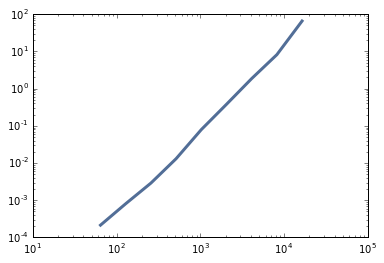

In [5]:
results = []
for N in ns:
    print(N)
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze1(ys, freqs, ts)
    results.append(result)

bests = [result.best for result in results]
plot_bests(bests)

Уклон близок к 2-ум, а не к 3-ём. Возможно, это из-за того, что производительность `np.linalg.solve` является почти квадратичной в данном диапазоне размеров массива.

При больших размерах массива уклон увеличивается, поэтому, возможно, он в конечном итоге сходится на 3.

Протестируем `analyze2`:

1000 loops, best of 1: 143 µs per loop
1000 loops, best of 1: 565 µs per loop
100 loops, best of 1: 2.22 ms per loop
100 loops, best of 1: 9.16 ms per loop
10 loops, best of 1: 38.8 ms per loop
10 loops, best of 1: 144 ms per loop
1 loops, best of 1: 588 ms per loop
1 loops, best of 1: 2.35 s per loop
1 loops, best of 1: 12.7 s per loop


2.0312154911232745

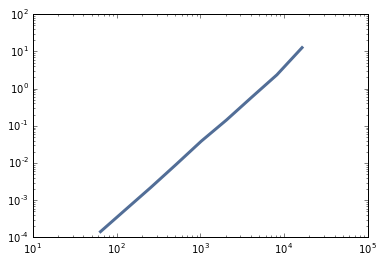

In [6]:
results = []
for N in ns:
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze2(ys, freqs, ts)
    results.append(result)

bests2 = [result.best for result in results]
plot_bests(bests2)

Результаты для `analyze2` ожидаемо образуют прямую линию с уклоном, близким к 2.

Протестируем `scipy.fftpack.dct`:

14.7 µs ± 352 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.5 µs ± 206 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.9 µs ± 810 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
16.2 µs ± 894 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
18 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
18.6 µs ± 86.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
23 µs ± 245 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
33.2 µs ± 546 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.5 µs ± 2.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
119 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
226 µs ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


0.36600750588651837

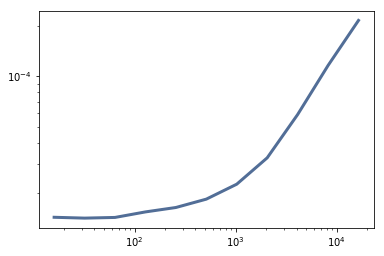

In [10]:
results = []
for N in ns:
    ys = noise.ys[:N]
    result = %timeit -o scipy.fftpack.dct(ys, type=3)
    results.append(result)

bests3 = [result.best for result in results]
plot_bests(bests3)

Эта реализация ДКП ощутимо быстрее. Фактически, как мы скоро увидим, время выполнения пропорционально nlog(n).

### Упражнение 6.2.
One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

In order to make this method practical, you need some way to store a sparse array; that is, an array where most of the elements are zero. NumPy provides several implementations of sparse arrays, which you can read about at http://docs.scipy.org/doc/scipy/reference/sparse.html

В качестве примера используем следующую запись скрипки:

In [11]:
wave = thinkdsp.read_wave('violin.wav')
wave.make_audio()

Выделим короткий сегмент:

In [12]:
segment = wave.segment(start=2, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП выделенного сегмента:

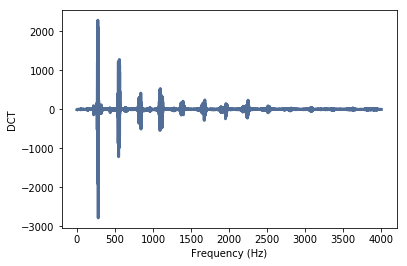

In [13]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

Видно несколько гармоник с существенной амплитудой и большое кол-во гармоник с амплитудой, близкой к нулю.

Функция, принимающая на вход ДКП и устанавливающая элементы ниже `thresh` в 0:

In [14]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим её к сегменту:

20155	22050	91.40589569160997


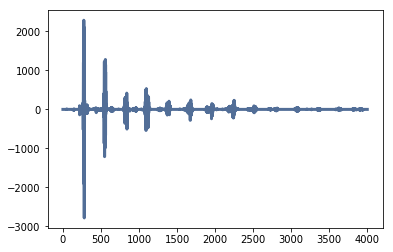

In [15]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

Исключению подверглось более 90% элементов.

Прослушаем изменённый сегмент:

In [16]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Заметной слуху разницы между сегментами нет.

Чтобы сжать более длинный сегмент, получим спектрограмму ДКП. Следующая функция похожа на `wave.make_spectrogram`, за исключением того, что она использует ДКП:

In [17]:
def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length / 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(int(i), int(j))
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return thinkdsp.Spectrogram(spec_map, seg_length)

Получим спектрограмму ДКП и применим `compress`  к каждому сегменту:

In [18]:
spectro = make_dct_spectrogram(wave, 1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.1)

1015	1024	99.12109375
1017	1024	99.31640625
1016	1024	99.21875
1016	1024	99.21875
1007	1024	98.33984375
1013	1024	98.92578125
1010	1024	98.6328125
986	1024	96.2890625
993	1024	96.97265625
996	1024	97.265625
988	1024	96.484375
878	1024	85.7421875
831	1024	81.15234375
789	1024	77.05078125
770	1024	75.1953125
776	1024	75.78125
725	1024	70.80078125
708	1024	69.140625
725	1024	70.80078125
713	1024	69.62890625
731	1024	71.38671875
687	1024	67.08984375
697	1024	68.06640625
720	1024	70.3125
707	1024	69.04296875
714	1024	69.7265625
728	1024	71.09375
736	1024	71.875
736	1024	71.875
728	1024	71.09375
746	1024	72.8515625
730	1024	71.2890625
750	1024	73.2421875
756	1024	73.828125
582	1024	56.8359375
694	1024	67.7734375
705	1024	68.84765625
707	1024	69.04296875
722	1024	70.5078125
725	1024	70.80078125
732	1024	71.484375
743	1024	72.55859375
727	1024	70.99609375
751	1024	73.33984375
743	1024	72.55859375
794	1024	77.5390625
756	1024	73.828125
677	1024	66.11328125
738	1024	72.0703125
761	1024	74.316406

В большинстве сегментов сжатие составляет 70-80%

Преобразуем спектрограмму обратно в wave и прослушаем:

In [19]:
wave2 = spectro.make_wave()
wave2.make_audio()

Исходная запись:

In [20]:
wave.make_audio()

Заметной слуху разницы нет.

Заметная разница появляется лишь при увеличении значения `trash` до 20

In [21]:
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1021	1024	99.70703125
1022	1024	99.8046875
1024	1024	100.0
1021	1024	99.70703125
1018	1024	99.4140625
1019	1024	99.51171875
1021	1024	99.70703125
1013	1024	98.92578125
1012	1024	98.828125
1012	1024	98.828125
1013	1024	98.92578125
945	1024	92.28515625
926	1024	90.4296875
883	1024	86.23046875
890	1024	86.9140625
859	1024	83.88671875
824	1024	80.46875
822	1024	80.2734375
831	1024	81.15234375
807	1024	78.80859375
838	1024	81.8359375
774	1024	75.5859375
803	1024	78.41796875
817	1024	79.78515625
808	1024	78.90625
825	1024	80.56640625
821	1024	80.17578125
828	1024	80.859375
837	1024	81.73828125
832	1024	81.25
846	1024	82.6171875
819	1024	79.98046875
840	1024	82.03125
830	1024	81.0546875
734	1024	71.6796875
786	1024	76.7578125
786	1024	76.7578125
821	1024	80.17578125
808	1024	78.90625
841	1024	82.12890625
829	1024	80.95703125
836	1024	81.640625
833	1024	81.34765625
841	1024	82.12890625
830	1024	81.0546875
864	1024	84.375
853	1024	83.30078125
773	1024	75.48828125
829	1024	80.95703125
845	1024	8

In [22]:
wave3 = spectro.make_wave()
wave3.make_audio()

### Упражнение 6.3.
In the repository for this book you will find a Jupyter notebook called `phase.ipynb` that explores the effect of phase on sound perception. Read through this notebook and run the examples. Choose another segment of sound and run the same experiments. Can you find any general relationships between the phase structure of a sound and how we perceive it?

`phase.ipynb` был просмотрен и разобран.

Рассмотрим, какое влияние оказывает изменение фазы на наше восприятие звука, выбрав в качестве примеров другие сегменты, относительно рассмотренных в `phase.ipynb`.

Начнём с сигнала пилообраной формы:

In [23]:
signal = thinkdsp.SawtoothSignal(freq=640, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.make_audio()

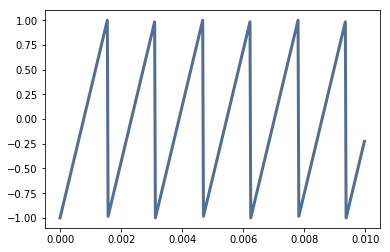

In [24]:
wave.segment(duration=0.01).plot()

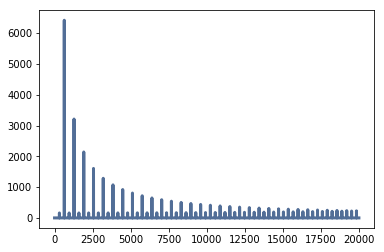

In [25]:
spectrum = wave.make_spectrum()
spectrum.plot()

Функция, отображающая угловую часть спектра:

In [26]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    thinkplot.plot(spectrum.fs, angles, style='x')
    thinkplot.config(xlim=[0, spectrum.max_freq], ylim =[-np.pi, np.pi])

На большинстве частот амплитуда мала, а угол относительно случаен. Так что результат будет весьма беспорядочным:

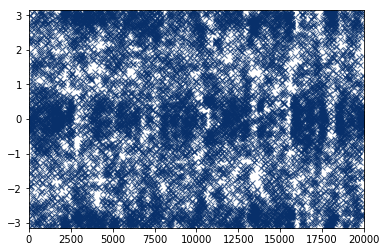

In [27]:
plot_angle(spectrum, thresh=0)
thinkplot.config(xlim=[0, spectrum.max_freq], ylim = [-np.pi, np.pi])

Но если мы выберем только частоты, на которых угол превышает некий порог, мы увидим, что в углах есть структура. Каждая гармоника смещена от предыдущей на долю радиана:

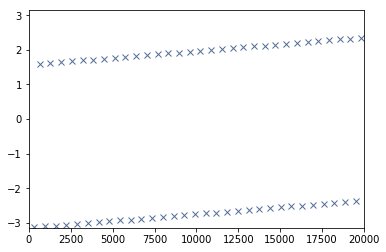

In [28]:
plot_angle(spectrum, thresh=1)
thinkplot.config(xlim=[0, spectrum.max_freq], ylim = [-np.pi, np.pi])

Следующая функция отображает амплитуды, углы и внешний вид волны для данного спектра:

In [29]:
def plot_three(spectrum, thresh=1):
    thinkplot.preplot(cols=3)
    spectrum.plot()
    thinkplot.subplot(2)
    plot_angle(spectrum, thresh=thresh)
    thinkplot.subplot(3)
    wave = spectrum.make_wave()
    wave.segment(duration=0.01).plot()
    wave.apodize()
    display(wave.make_audio())

Визуализируем исходный спектр:

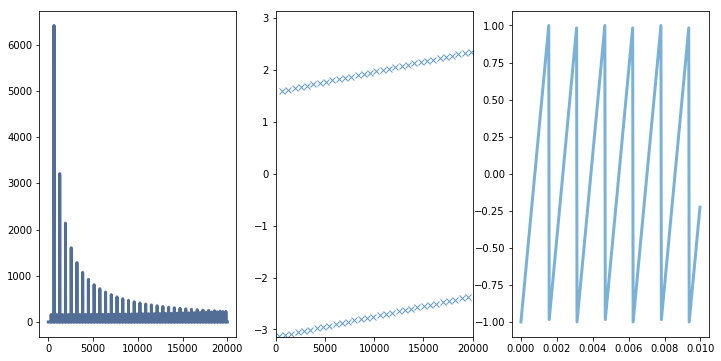

In [30]:
plot_three(spectrum)

Обнулим все углы и посмотрим на результат:

In [31]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

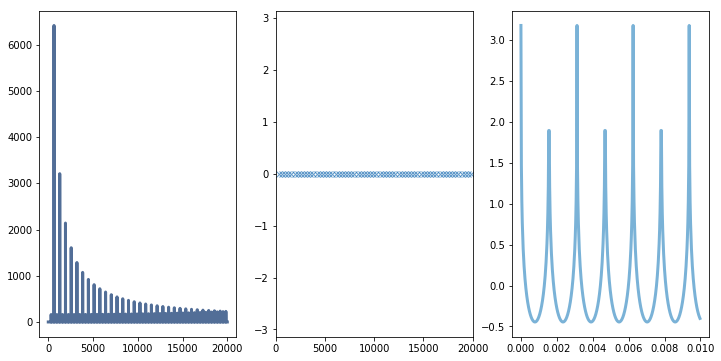

In [32]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

Амплитуды не изменились, все углы стали равны нулю, график волны сильно изменился. Но, при этом, волна звучит почти так же. Единственное заметное отличие заключается в том, что громкость кажется ниже.

Умножение комплексных компонент на $\exp(i\phi)$ даст эффект сложения углов с $\phi$:

In [33]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

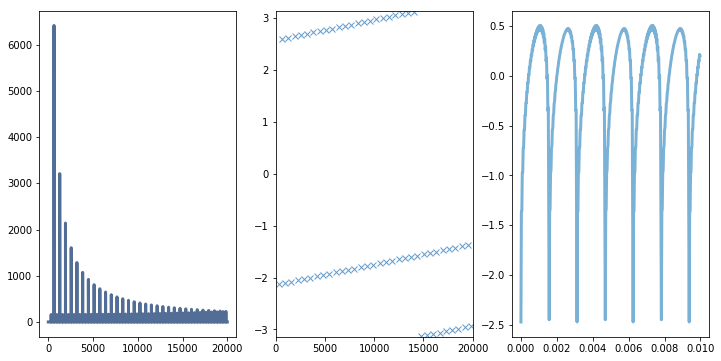

In [34]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3)

Опять же, график волны сильно отличается от предыдущих, но воспиринимается звук при этом почти также.

Теперь зададим углам случайные значения:

In [35]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

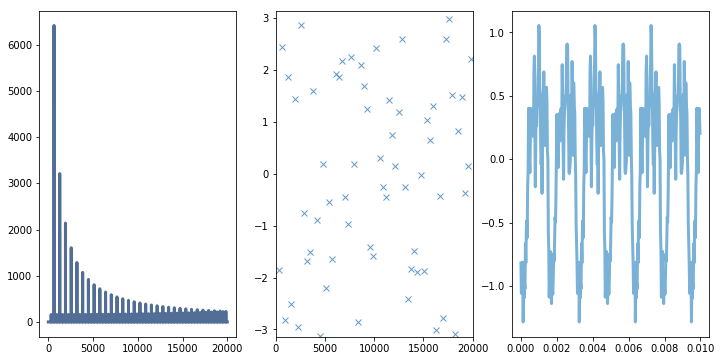

In [36]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4)

Воспринимаемый звук всё ещё остаётся почти неизменным.

С более естественными звуками результаты несколько иные. Рассмотрим следующую запись гобоя:

In [37]:
wave = thinkdsp.read_wave('120994__thirsk__120-oboe.wav')
wave.make_audio()

Выделим короткий сегмент:

In [38]:
segment = wave.segment(start=7.5, duration=0.5)

Визуализируем его спектр:

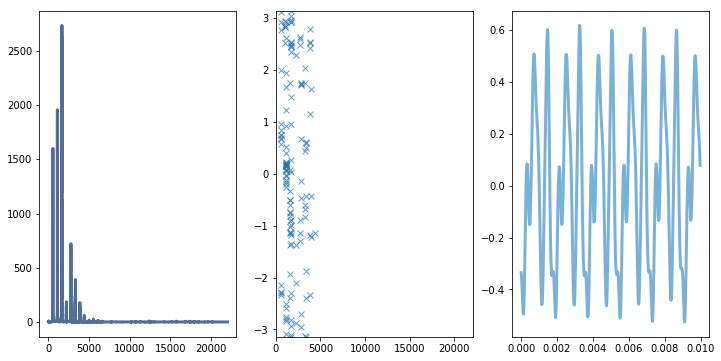

In [39]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Обнулим все углы:

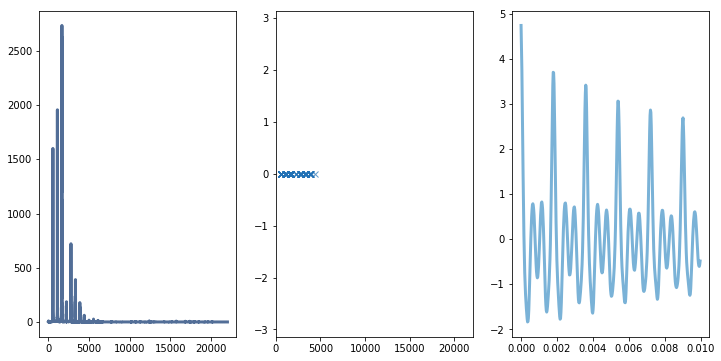

In [40]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Повернём углы на 1 радиан:

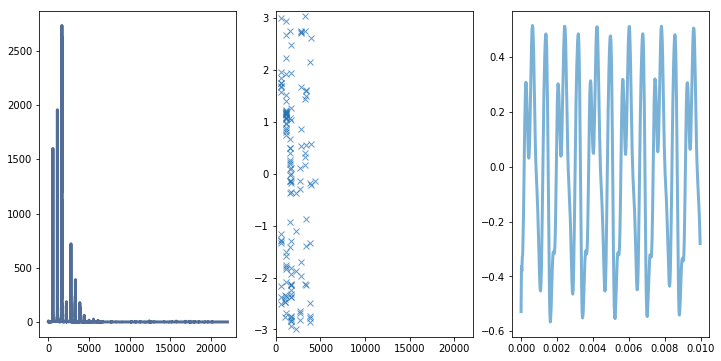

In [41]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Зададим углам случайные значения:

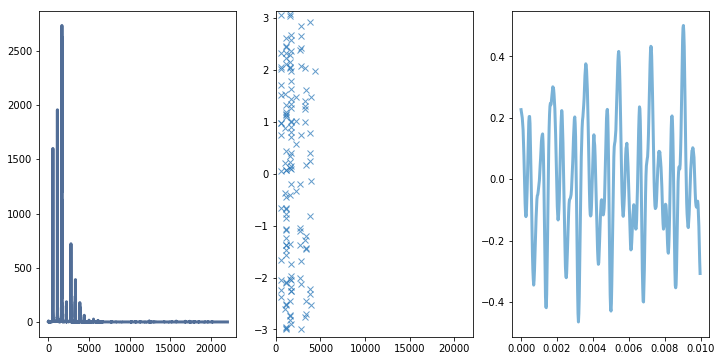

In [42]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Обнуление углов, кажется, уменьшает громкость, вращение углов не имеет никакого эффекта, а рандомизация углов дает звуку намек на эфирное качество.

Проделаем те же действия с записью саксофона:

In [43]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()
segment = wave.segment(start=2.5, duration=0.5)

Визуализируем спектр выделенного сегмента:

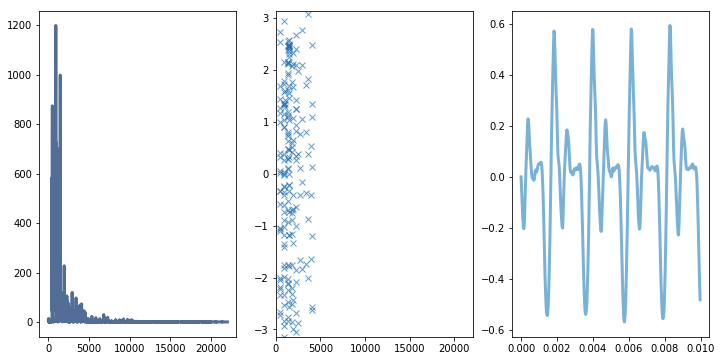

In [44]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Обнулим все углы:

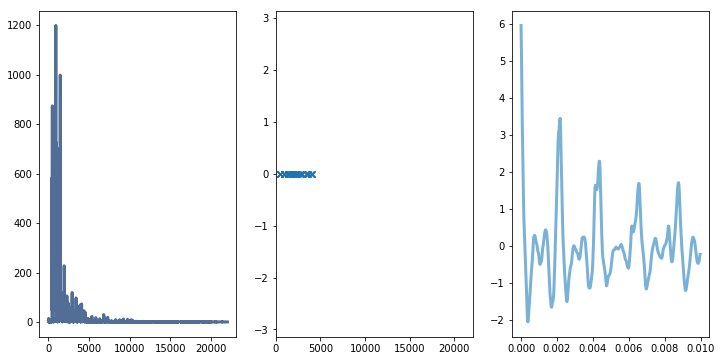

In [45]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Повернём углы на 1 радиан:

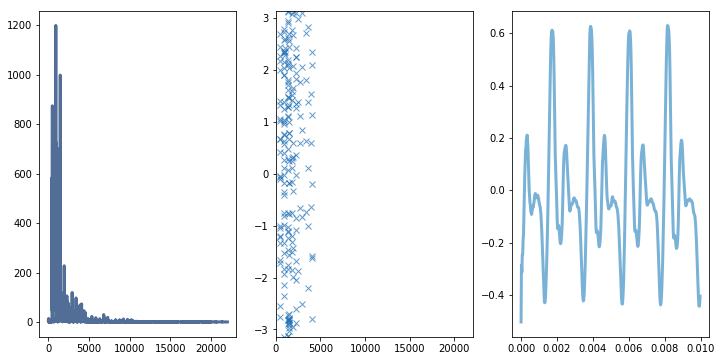

In [46]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Зададим углам случайные значения:

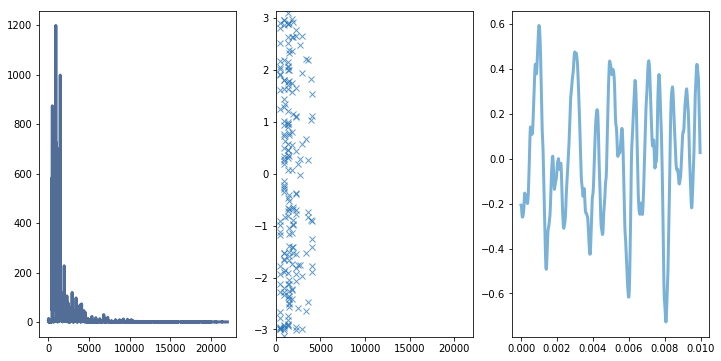

In [47]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Опять же, обнуление, кажется, уменьшает громкость, вращение не имеет никакого эффекта, а рандомизация добавляет некоторый эффект.

Одним из отличий саксофона от других звуков является то, что основной компонент не является доминирующим. Для таких звуков ухо использует нечто вроде автокорреляции в дополнение к спектральному анализу, и возможно, что этот вторичный режим анализа более чувствителен к фазовой структуре.

Если это так, эффект должен быть более глубоким, когда основная частота отсутствует вообще.

Отфильтруем основную частоту и повторим эксперимент:

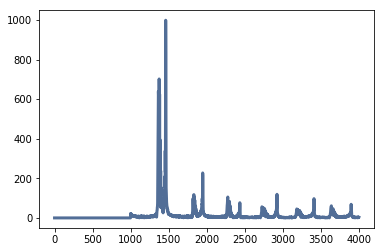

In [48]:
spectrum.high_pass(1000)
spectrum.plot(high=4000)

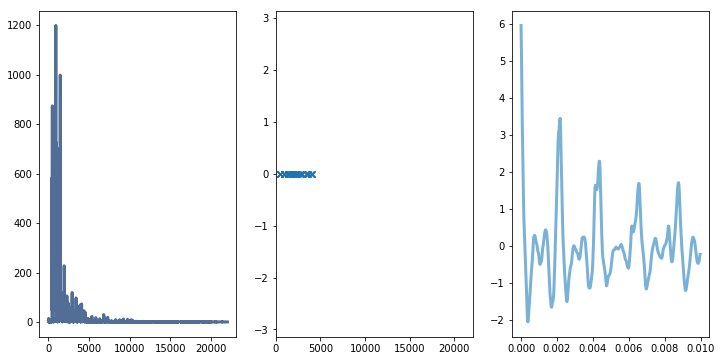

In [49]:
plot_three(spectrum2, thresh=50)

Обнулим все углы:

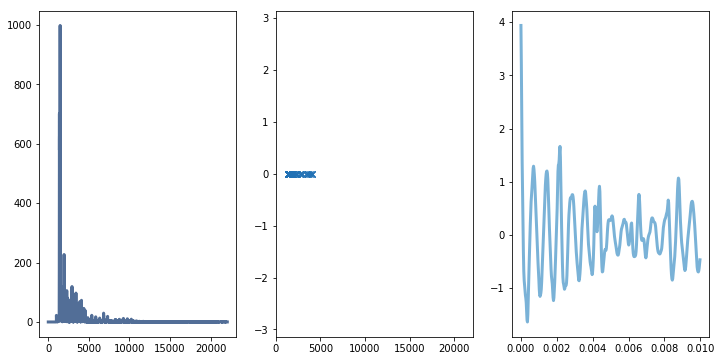

In [50]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Повернём углы на 1 радиан:

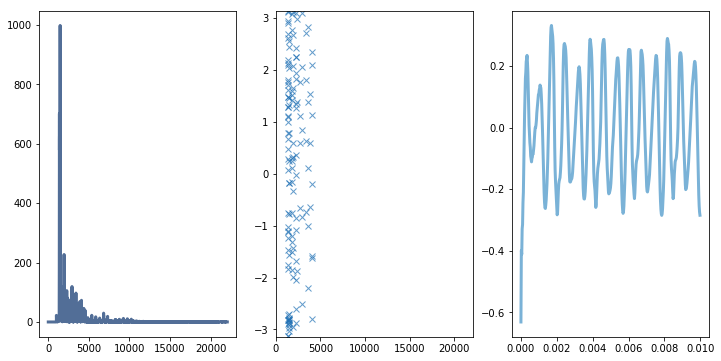

In [51]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Зададим углам случайные значения:

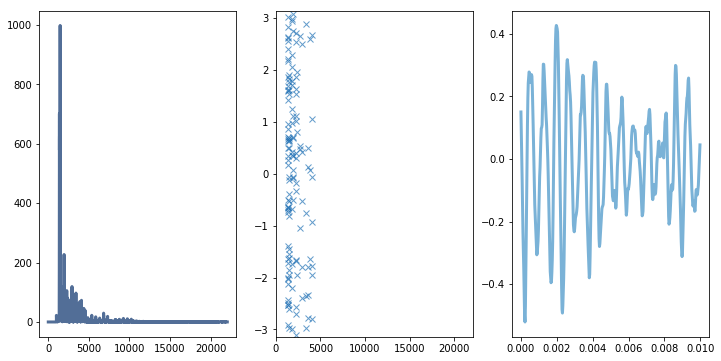

In [52]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Для этого сегмента изменение фазовой структуры имеет слышимый эффект, особенно рандомизация.

Если ухо использует что-то вроде автокорреляции для анализа подобных звуков, мы можем ожидать изменения функции автокорреляции при изменении фазовой структуры.

Следующие функции отображают ACF для данных сегментов:

In [53]:
def autocorr(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

In [54]:
def plot_acf(spectrum):
    corrs = autocorr(spectrum.make_wave())
    thinkplot.plot(corrs[:200], linewidth=1)

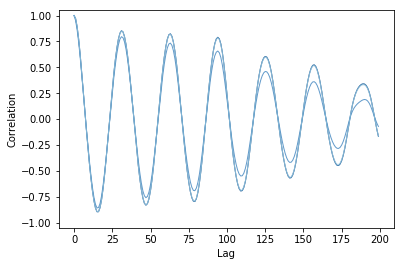

In [55]:
plot_acf(spectrum)
plot_acf(spectrum2)
plot_acf(spectrum3)
plot_acf(spectrum4)
thinkplot.config(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

Изменение фазовой структуры оказывает некоторое влияние на ACF, но там нет ничего, что очевидно бы объясняло изменения в воспринимаемом звуке.

В итоге:

1. По крайней мере для звуков, имеющих простую гармоническую структуру, мы не слышим изменений в фазовой структуре, при условии, что гармоническая структура остаётся неизменной.

2. Возможное исключение - звуки с низкой амплитудой на основной частоте. В этом случае мы используем что-то вроде автокорреляции для восприятия высоты тона и этот анализ может быть более чувствительным к фазовой структуре.

3. Однако в ACF нет ничего очевидного, что объясняло бы этот эффект.